In [61]:
# Helper Scripts Run Notebook #

In [1]:
# Imports

import torch
from torch import nn, optim
from torch.utils.data import DataLoader

from torchvision import models, datasets, transforms
from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights

from torchinfo import summary
from torch.optim.lr_scheduler import StepLR

from PIL import Image
from datetime import datetime
import hashlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from sklearn.metrics import (
    classification_report
    , confusion_matrix
    , ConfusionMatrixDisplay
)

from timeit import default_timer as timer
from tqdm import tqdm
import os
import random
import warnings
warnings.filterwarnings("ignore")

print("torch:", torch.__version__)

torch: 2.2.2


In [2]:
# Device selection (CUDA -> MPS -> CPU)

if torch.cuda.is_available():
    device = "cuda"  # NVIDIA GPU
elif torch.backends.mps.is_available():
    device = "mps"   # Apple Silicon
else:
    device = "cpu"   # CPU fallback

print("device:", device)

device: mps


In [3]:
from helper_scripts.t0rch_h3lp3r_0x01 import (
    train_model
    , evaluate_model
    , evaluate_model_with_cm_params
    , list_test_images
    , show_image_prediction
    , plot_training_curves_seaborn
    , plot_training_curves
    , compute_image_hash
    , find_duplicate_images
)

Device: mps


In [ ]:
# pip install kagglehub

In [4]:
# os.cpu_count()
int(os.cpu_count() *0.25)
# max(0, min(2, (os.cpu_count() or 2) // 2))

4

In [5]:
# Load the data from the drive:

train_dir = "./data/cars_image_dataset/train/"
test_dir = "./data/cars_image_dataset/test/"

train_dir, test_dir

('./data/cars_image_dataset/train/', './data/cars_image_dataset/test/')

In [6]:
# For init pretrained backbone - EfficientNet_B2 (*For small "toy" sets, EfficientNet_B2 and ConvNeXt-Tiny are both strong.) If acc/loss is not great, swap to ConvNeXt-Tiny by uncommenting the alt block below.

# --- Default: EfficientNet_B2 ---
weights = models.EfficientNet_B2_Weights.IMAGENET1K_V1
model = models.efficientnet_b2(weights=weights)
preprocess = weights.transforms()

In [8]:
# Use the preprocess transform for EfficientNet_B2 (preprocess)

num_workers=int(os.cpu_count() *0.25) 

train_dataset = datasets.ImageFolder(
    root=train_dir
    , transform=preprocess
)

test_dataset = datasets.ImageFolder(
    root=test_dir
    , transform=preprocess
)

train_loader = DataLoader(
    dataset=train_dataset
    , batch_size=32
    , shuffle=True
    , num_workers=num_workers # was 2, now trying 25% of cpu count (4)
)

test_loader = DataLoader(
    dataset=test_dataset
    , batch_size=32
    , shuffle=False
    , num_workers=num_workers # was 2, now trying 25% of cpu count (4)
)

len(train_dataset), len(test_dataset)

(3352, 813)

In [9]:
# Derive class names dynamically (no hardcoding)
class_names = train_dataset.classes
num_classes = len(class_names)
print("Number of classes:", num_classes)
print("Detected classes:", class_names)

Number of classes: 7
Detected classes: ['Audi', 'Hyundai Creta', 'Mahindra Scorpio', 'Rolls Royce', 'Swift', 'Tata Safari', 'Toyota Innova']


In [11]:
preprocess

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [31]:
### Take a peek at some of the data to get a feel for the shapes, batches, etc.

In [12]:
# get one batch
images, labels = next(iter(train_loader))

print("images.shape:", images.shape)   # e.g. torch.Size([32, 3, H, W])
print("labels.shape:", labels.shape)   # e.g. torch.Size([32])

images.shape: torch.Size([32, 3, 288, 288])
labels.shape: torch.Size([32])


In [13]:
import random
idx = random.randrange(len(train_dataset))
img, label = train_dataset[idx]
print("dataset sample shape:", img.shape)   # e.g. torch.Size([3, H, W])
print("label:", label)

dataset sample shape: torch.Size([3, 288, 288])
label: 2


In [14]:
# get a single img (random - by index int)

images, labels = next(iter(train_loader))
i = torch.randint(len(images), (1,)).item()   # random index in the batch
print(f"sample index: {i}")
print("single image shape:", images[i].shape)  # e.g. torch.Size([3, H, W])
print("single label:", labels[i].item())

sample index: 1
single image shape: torch.Size([3, 288, 288])
single label: 0


In [32]:
# Start building the model & hyperparams;

In [15]:
# UPDATED EffNetB2 --> w/ 2 add'l layers unfrozen;
# (Next option if not significant increase in metrix --> adjust preprocess: img size to 300 & batches of 16;)

model = model

for p in model.parameters():
    p.requires_grad = False

in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, num_classes)

# Unfreeze last 2 blocks
n_unfreeze = 2
total_blocks = len(model.features)
for i in range(total_blocks - n_unfreeze, total_blocks):
    for p in model.features[i].parameters():
        p.requires_grad = True

model = model.to(device)

# Optimizer with two groups
backbone_params = [p for m in model.features[total_blocks - n_unfreeze:] for p in m.parameters() if p.requires_grad]
head_params = list(model.classifier.parameters())

# Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW([
    {"params": backbone_params, "lr": 1e-4, "weight_decay": 1e-4}
    , {"params": head_params,     "lr": 5e-4, "weight_decay": 5e-5},
])

# Keep your StepLR or switch to cosine
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)

In [16]:
%%time
# Running our training loop from 'train_model' function within helper script;

train_losses, train_accuracies = train_model(
    model=model
    , train_loader=train_loader
    , criterion=criterion
    , optimizer=optimizer
    , scheduler=scheduler
    , epochs=6
)

 17%|██████▏                              | 1/6 [01:27<07:18, 87.78s/it]

Epoch 1/6 | Loss: 1.2334 | Acc: 59.5465% | LR: 0.000100


 33%|████████████▎                        | 2/6 [02:30<04:52, 73.24s/it]

Epoch 2/6 | Loss: 0.5020 | Acc: 86.2172% | LR: 0.000100


 50%|██████████████████▌                  | 3/6 [03:34<03:26, 68.76s/it]

Epoch 3/6 | Loss: 0.2769 | Acc: 92.5418% | LR: 0.000100


 67%|████████████████████████▋            | 4/6 [04:35<02:11, 65.94s/it]

Epoch 4/6 | Loss: 0.1648 | Acc: 96.3007% | LR: 0.000100


 83%|██████████████████████████████▊      | 5/6 [05:36<01:04, 64.06s/it]

Epoch 5/6 | Loss: 0.1038 | Acc: 97.5537% | LR: 0.000080


100%|█████████████████████████████████████| 6/6 [06:37<00:00, 66.25s/it]

Epoch 6/6 | Loss: 0.0824 | Acc: 98.1504% | LR: 0.000080
CPU times: user 1min 48s, sys: 58.6 s, total: 2min 46s
Wall time: 6min 37s


In [17]:
import pandas as pd

# Build DataFrame from history (will code this in earlier in a later update;)
df_metrics = pd.DataFrame({
    "Epoch": range(1, len(train_losses) + 1)
    , "Train Loss": train_losses
    , "Train Accuracy": train_accuracies
})

df_metrics.tail(3)

Epoch  Train Loss  Train Accuracy
3      4    0.164798       96.300716
4      5    0.103832       97.553699
5      6    0.082351       98.150358

In [18]:
df_metrics['Train Loss'].min(), df_metrics['Train Accuracy'].max()

(0.08235117458785064, 98.15035799522673)

In [22]:
# current_date = datetime.now().strftime("%Y-%m-%d")

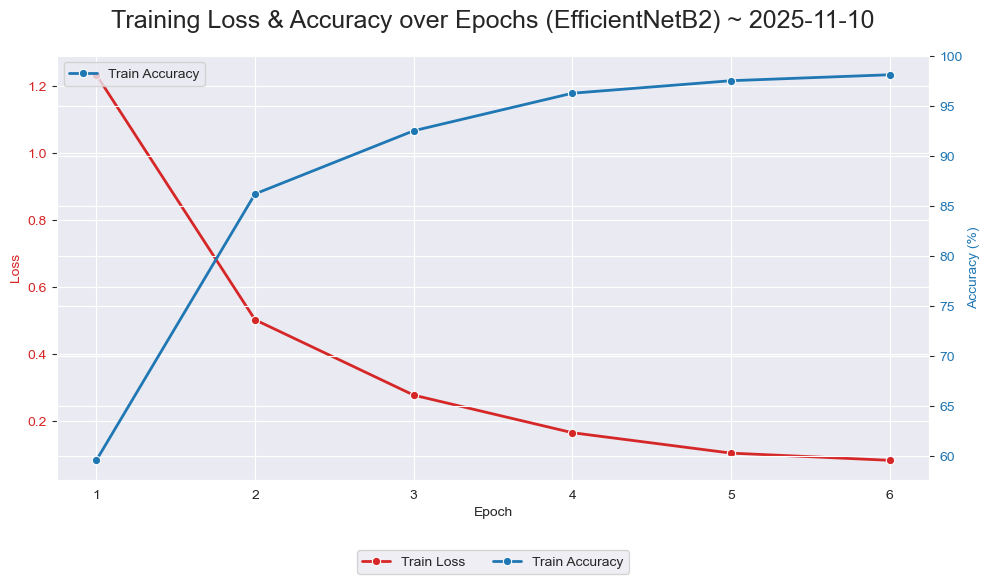

In [19]:
plot_training_curves_seaborn(
    df_metrics
    , x_col="Epoch"
    , loss_col="Train Loss"
    , acc_col="Train Accuracy"
    , title=f"Training Loss & Accuracy over Epochs (EfficientNetB2)"
)

In [20]:
# Running Test Loop on EfficientNet using our helper eval script (w/ built-in sklearn metrix options!)

test_acc, all_preds, all_labels = evaluate_model_with_cm_params(
    model=model
    , test_loader=test_loader
    , device=device
)

Test Accuracy: 94.9569%


In [ ]:
# We might be able to squeeze some better metrix out of this with a few more epochs!!!

In [21]:
%%time
### SECOND / FOLLOW-UP TRAINING RUN ("Retrain") ###

# EfficientNet_B2 Training Loop *** With tqdm progress bar AND stored loss/acc for plotting in next cell;

train_losses, train_accuracies = train_model(
    model=model
    , train_loader=train_loader
    , criterion=criterion
    , optimizer=optimizer
    , scheduler=scheduler
    , epochs=12
    , device=device
)

  8%|███                                 | 1/12 [01:03<11:39, 63.55s/it]

Epoch 1/12 | Loss: 0.0591 | Acc: 98.7470% | LR: 0.000080


 17%|██████                              | 2/12 [02:07<10:40, 64.07s/it]

Epoch 2/12 | Loss: 0.0513 | Acc: 98.9558% | LR: 0.000080


 25%|█████████                           | 3/12 [03:10<09:31, 63.52s/it]

Epoch 3/12 | Loss: 0.0468 | Acc: 98.9260% | LR: 0.000080


 33%|████████████                        | 4/12 [04:12<08:22, 62.83s/it]

Epoch 4/12 | Loss: 0.0372 | Acc: 99.1647% | LR: 0.000064


 42%|███████████████                     | 5/12 [05:15<07:18, 62.71s/it]

Epoch 5/12 | Loss: 0.0351 | Acc: 99.4033% | LR: 0.000064


 50%|██████████████████                  | 6/12 [06:17<06:15, 62.67s/it]

Epoch 6/12 | Loss: 0.0297 | Acc: 99.4033% | LR: 0.000064


 58%|█████████████████████               | 7/12 [07:19<05:11, 62.30s/it]

Epoch 7/12 | Loss: 0.0277 | Acc: 99.4630% | LR: 0.000064


 67%|████████████████████████            | 8/12 [08:19<04:06, 61.70s/it]

Epoch 8/12 | Loss: 0.0315 | Acc: 99.1945% | LR: 0.000064


 75%|███████████████████████████         | 9/12 [09:20<03:04, 61.40s/it]

Epoch 9/12 | Loss: 0.0254 | Acc: 99.3437% | LR: 0.000051


 83%|█████████████████████████████▏     | 10/12 [10:21<02:02, 61.22s/it]

Epoch 10/12 | Loss: 0.0270 | Acc: 99.3138% | LR: 0.000051


 92%|████████████████████████████████   | 11/12 [11:21<01:01, 61.04s/it]

Epoch 11/12 | Loss: 0.0200 | Acc: 99.6122% | LR: 0.000051


100%|███████████████████████████████████| 12/12 [12:21<00:00, 61.83s/it]

Epoch 12/12 | Loss: 0.0213 | Acc: 99.4928% | LR: 0.000051
CPU times: user 3min 24s, sys: 1min 53s, total: 5min 18s
Wall time: 12min 21s


In [22]:
# Build another DataFrame from history (will code this in earlier in a later update;)

df_metrics_final = pd.DataFrame({
    "Epoch": range(1, len(train_losses) + 1)
    , "Train Loss": train_losses
    , "Train Accuracy": train_accuracies
})

df_metrics_final.tail(3)

Epoch  Train Loss  Train Accuracy
9      10    0.027044       99.313842
10     11    0.020050       99.612172
11     12    0.021280       99.492840

In [23]:
# Note - since it makes sense to append the epochs from both train loops rather than plotting separate append the two but tweek the latter to continue epochs chronologically(e.g., since df_metrics epochs are 1..6, df_metrics_final should be 7..15)

last_epoch = df_metrics['Epoch'].max()                # e.g. 6
df_metrics_final_shifted = df_metrics_final.copy()    # avoid mutating original
df_metrics_final_shifted['Epoch'] = df_metrics_final_shifted['Epoch'] + last_epoch

df_metrics_all = pd.concat([df_metrics, df_metrics_final_shifted], ignore_index=True)
df_metrics_all.tail(3)

Epoch  Train Loss  Train Accuracy
15     16    0.027044       99.313842
16     17    0.020050       99.612172
17     18    0.021280       99.492840

In [24]:
df_metrics_all['Train Loss'].min(), df_metrics_all['Train Accuracy'].max(), 

(0.020049823246905157, 99.61217183770883)

In [25]:
# Plotting the overall training loss/acc curves w/ plotly express, for interactive:

plot_training_curves(
    df_metrics_all
    , x_col="Epoch"
    , loss_col="Train Loss"
    , acc_col="Train Accuracy"
    , title=f"Training Loss & Accuracy over Epochs (EfficientNetB2)"
)

In [26]:
# Running final test loop on EfficientNetB2 unfrozen model:

test_acc2, all_preds, all_labels = evaluate_model_with_cm_params(
    model=model
    , test_loader=test_loader
    , device=device
)

Test Accuracy: 96.5560%


In [ ]:
# Previous Test Accuracy (day prior): 95.8180%
# Previous Test Accuracy (yesterday): 95.9510%

In [28]:
# Set up a 'saved_models' directory (if it doesnt already exist):
from datetime import datetime

# Derive model name automatically 
weights_str = str(weights) # 'EfficientNet_B2_Weights.IMAGENET1K_V1' 
# ^^^Need to update this in other scripts as I wont always be using 'eff'...

named_model = weights_str.split('_Weights')[0]  # 'EfficientNet_B2'

# Save directory setup
save_dir = "./saved_models/"
os.makedirs(save_dir, exist_ok=True)

# Add the current date to the filename
current_date_file = datetime.now().strftime("%Y%m%d") # Tweaked var name so this can have no '-';

# --- Build filename dynamically ---
model_save_path = os.path.join(
    save_dir
    , f"{named_model.lower()}_cars_7-class_{current_date_file}_unfrzn_lyrs_99-6trn_96-5tst.pth"
)
print(model_save_path)

./saved_models/efficientnet_b2_cars_7-class_20251110_unfrzn_lyrs_99-6trn_96-5tst.pth


In [29]:
# Save the trained model to .pth

# Save only the parameters
torch.save(model.state_dict(), model_save_path)
print(f"Model state_dict saved to: {model_save_path}")

Model state_dict saved to: ./saved_models/efficientnet_b2_cars_7-class_20251110_unfrzn_lyrs_99-6trn_96-5tst.pth


In [38]:
device

'mps'

In [31]:
test_items, test_by_class = list_test_images(
    test_dir
    , class_names
)

print(f"Found {len(test_items)} test images across {len(class_names)} classes.")
for cls in class_names:
    print(f"  {cls:20s}: {len(test_by_class.get(cls, []))}")

Found 813 test images across 7 classes.
  Audi                : 199
  Hyundai Creta       : 67
  Mahindra Scorpio    : 75
  Rolls Royce         : 74
  Swift               : 102
  Tata Safari         : 106
  Toyota Innova       : 190


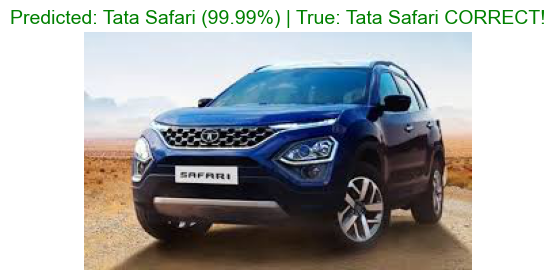

Class probabilities:
       Audi                :  0.0021%
       Hyundai Creta       :  0.0020%
       Mahindra Scorpio    :  0.0009%
       Rolls Royce         :  0.0001%
       Swift               :  0.0004%
* True Tata Safari         : 99.9936%
       Toyota Innova       :  0.0009%


In [32]:
# Show ONE truly random test image (from any class)

assert len(test_items) > 0, "No test images found."
rand_path, rand_true = random.choice(test_items)

show_image_prediction(
    img_path=rand_path
    , model=model
    , preprocess=preprocess
    , class_names=class_names
    , device=device
    , true_label=rand_true
)

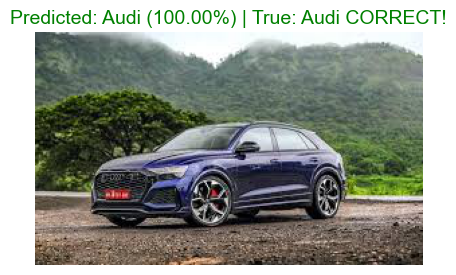

Class probabilities:
* True Audi                : 99.9991%
       Hyundai Creta       :  0.0000%
       Mahindra Scorpio    :  0.0000%
       Rolls Royce         :  0.0007%
       Swift               :  0.0001%
       Tata Safari         :  0.0001%
       Toyota Innova       :  0.0000%


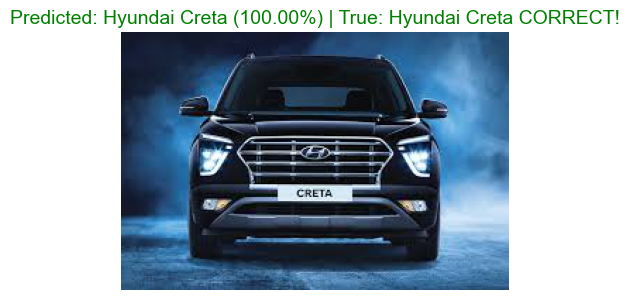

Class probabilities:
       Audi                :  0.0001%
* True Hyundai Creta       : 99.9970%
       Mahindra Scorpio    :  0.0005%
       Rolls Royce         :  0.0001%
       Swift               :  0.0000%
       Tata Safari         :  0.0000%
       Toyota Innova       :  0.0023%


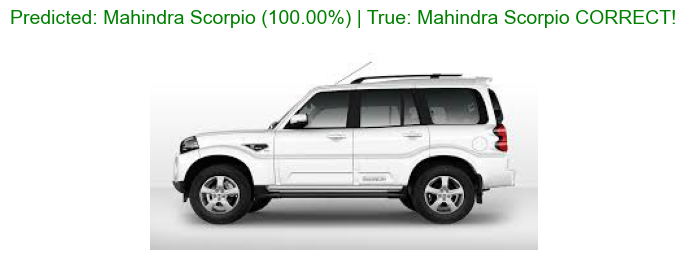

Class probabilities:
       Audi                :  0.0003%
       Hyundai Creta       :  0.0002%
* True Mahindra Scorpio    : 99.9952%
       Rolls Royce         :  0.0016%
       Swift               :  0.0016%
       Tata Safari         :  0.0000%
       Toyota Innova       :  0.0010%


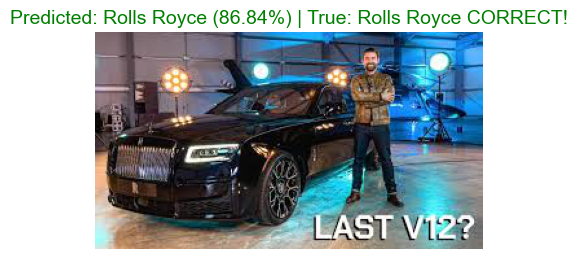

Class probabilities:
       Audi                :  2.2254%
       Hyundai Creta       :  0.0002%
       Mahindra Scorpio    :  0.0684%
* True Rolls Royce         : 86.8390%
       Swift               :  0.0017%
       Tata Safari         : 10.8651%
       Toyota Innova       :  0.0001%


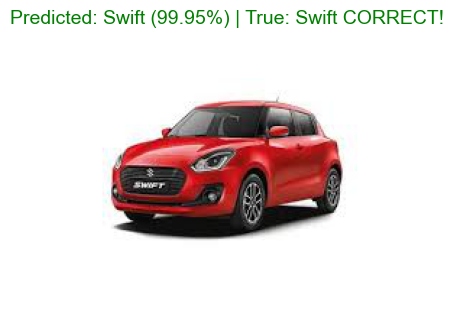

Class probabilities:
       Audi                :  0.0008%
       Hyundai Creta       :  0.0109%
       Mahindra Scorpio    :  0.0041%
       Rolls Royce         :  0.0018%
* True Swift               : 99.9453%
       Tata Safari         :  0.0001%
       Toyota Innova       :  0.0370%


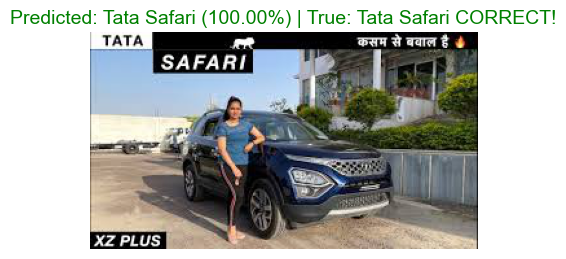

Class probabilities:
       Audi                :  0.0000%
       Hyundai Creta       :  0.0001%
       Mahindra Scorpio    :  0.0000%
       Rolls Royce         :  0.0000%
       Swift               :  0.0000%
* True Tata Safari         : 99.9998%
       Toyota Innova       :  0.0000%


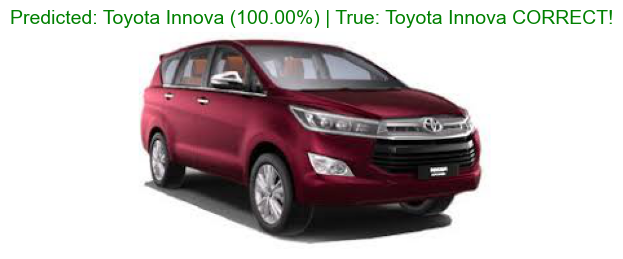

Class probabilities:
       Audi                :  0.0000%
       Hyundai Creta       :  0.0002%
       Mahindra Scorpio    :  0.0000%
       Rolls Royce         :  0.0008%
       Swift               :  0.0002%
       Tata Safari         :  0.0001%
* True Toyota Innova       : 99.9988%


In [33]:
# Show ONE random image PER CLASS (balanced peek)

for cls in class_names:
    candidates = test_by_class.get(cls, [])
    if not candidates:
        print(f"[skip] No images found for class: {cls}")
        continue
    img_path = random.choice(candidates)
    show_image_prediction(
        img_path=img_path   
        , model=model    
        , preprocess=preprocess    
        , class_names=class_names   
        , device=device    
        , true_label=cls
    )

### NEXT --> BUILD CONFUSION MATRIX (text & plot), classification_report; ###

In [34]:
test_acc, test_acc2

(94.95694956949569, 96.5559655596556)

In [35]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay


print(classification_report(all_labels, all_preds, digits=4))
confusion_matrix(all_labels, all_preds)

              precision    recall  f1-score   support

           0     0.9557    0.9749    0.9652       199
           1     0.9254    0.9254    0.9254        67
           2     0.9867    0.9867    0.9867        75
           3     0.9701    0.8784    0.9220        74
           4     0.9615    0.9804    0.9709       102
           5     0.9810    0.9717    0.9763       106
           6     0.9740    0.9842    0.9791       190

    accuracy                         0.9656       813
   macro avg     0.9649    0.9574    0.9608       813
weighted avg     0.9657    0.9656    0.9654       813



array([[194,   2,   0,   1,   1,   1,   0],
       [  1,  62,   0,   1,   1,   1,   1],
       [  0,   0,  74,   0,   1,   0,   0],
       [  7,   1,   1,  65,   0,   0,   0],
       [  0,   0,   0,   0, 100,   0,   2],
       [  0,   1,   0,   0,   0, 103,   2],
       [  1,   1,   0,   0,   1,   0, 187]])

<Figure size 1200x1200 with 0 Axes>

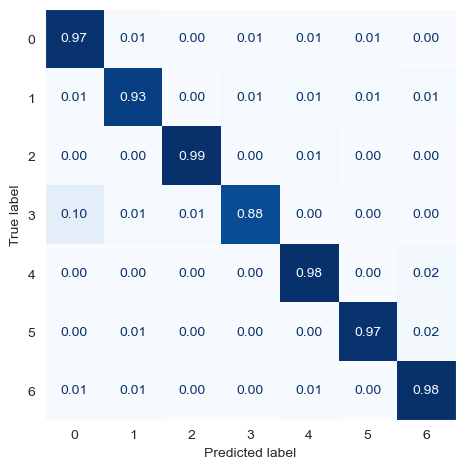

In [36]:
%matplotlib inline 

plt.figure(figsize=(12, 12)) 

disp = ConfusionMatrixDisplay.from_predictions(
    all_labels, all_preds
    , normalize="true", cmap="Blues", colorbar=False
)

plt.gca().grid(False)

# replace default annotations with two-decimal strings
for txt in plt.gca().texts: txt.set_text(f"{float(txt.get_text()):.2f}")
plt.tight_layout()
plt.show();

In [37]:
class_names

['Audi',
 'Hyundai Creta',
 'Mahindra Scorpio',
 'Rolls Royce',
 'Swift',
 'Tata Safari',
 'Toyota Innova']

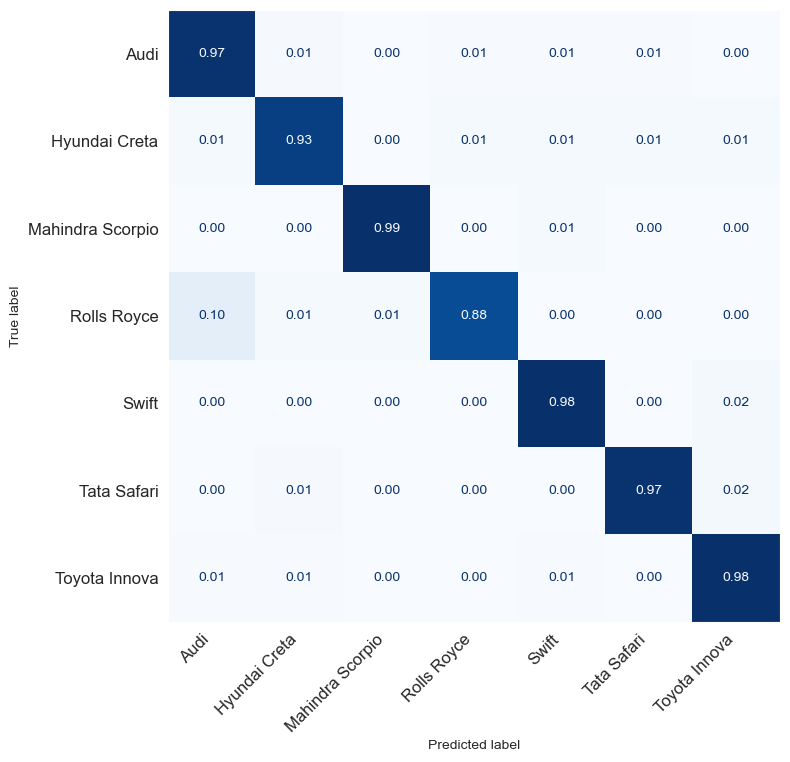

In [47]:
# Create a larger figure with higher DPI
plt.figure(figsize=(8, 9), dpi=100)  # Increased figsize and DPI

# Create the confusion matrix display
disp = ConfusionMatrixDisplay.from_predictions(
    all_labels, all_preds
    , normalize="true"
    , cmap="Blues"
    , colorbar=False
    , display_labels=class_names
    , ax=plt.gca()  # Use the current axes
)

# Remove grid lines
plt.gca().grid(False)

# Replace default annotations with two-decimal strings
for txt in plt.gca().texts:
    txt.set_text(f"{float(txt.get_text()):.2f}")

# Adjust layout to maximize the use of figure space
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

# Optionally, rotate x-axis labels for better readability if needed
plt.xticks(rotation=45, ha="right", fontsize=12)  # Increased font size
plt.yticks(fontsize=12)  # Increased font size

plt.tight_layout()
plt.show();

In [ ]:
### Test on actually unseen images from the internet!!! ###

In [48]:
train_dir, test_dir

('./data/cars_image_dataset/train/', './data/cars_image_dataset/test/')

In [49]:
# Run the helper function to make sure the 'unseen' imgs (which I grabbed from the internet to get truly 'unseen' data for test - are not already included in the actual train/test datasets used in building the model;)

unseen_dir = './data/unseen_cars/'
# train_dir = './' # If already assigned in dataloader phase, comment out;
# test_dir = './' # If already assigned in dataloader phase, comment out;

# Call the function with verbose=True (default)
duplicates = find_duplicate_images(unseen_dir, train_dir, test_dir)

No duplicate images found. All images are truly unseen.


In [52]:
from torchinfo import summary

In [96]:
# get a batch shape for summary
# images, labels = next(iter(train_loader))

input_shape = images.shape

In [97]:
input_shape

torch.Size([32, 3, 288, 288])

In [98]:
from torchinfo import summary
import torch

# Convert the input_shape to a tuple
input_size = input_shape

# Print a summary using torchinfo
summary(model=model,
        input_size=input_size  # Use the dynamically generated input_size
        , col_names=["input_size"
                     # , "output_size" # can have input_size or output_size (not both) due to size constraints
                     # ^ (cont.) I also find adjusting nb to '100% width' often breaks other things;
                     , "num_params"
                     , "trainable"
                    ]
        , col_width=20
        , row_settings=["var_names"]
       )

Layer (type (var_name))                                      Input Shape          Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 288, 288]    --                   Partial
├─Sequential (features)                                      [32, 3, 288, 288]    --                   Partial
│    └─Conv2dNormActivation (0)                              [32, 3, 288, 288]    --                   False
│    │    └─Conv2d (0)                                       [32, 3, 288, 288]    (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 144, 144]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 144, 144]   --                   --
│    └─Sequential (1)                                        [32, 32, 144, 144]   --                   False
│    │    └─MBConv (0)                                       [32, 32, 144, 144]   (1,448)              False
│    │    └─MB